Sales - obrót handlowy w danym dniu (to jest to, co prognozujesz) 

W analizie danych poszukujemy czynników wpływających na sprzedaż, tak, żeby po ich określeniu można było dokonać predykcji sprzedaży w pewnym horyzoncie czasu oraz zrozumieć relację między czynnikiem a wielkością sprzedaży.

Wszystkie pliki znajdują się bezpośrednio w tym samym katalogu co notebook. 

## FAZA I

# Wczytanie i obróbka danych 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
store_data = pd.read_csv('store_data.csv', dtype={'StateHoliday': str}, parse_dates=['Date'])
store_info = pd.read_csv('store.csv')
store_states = pd.read_csv('store_states.csv')
weather_data = pd.read_csv('weather.csv', parse_dates=['Date'])
state_names = pd.read_csv('state_names.csv')

Sprawdzanie brakujących wartości

In [3]:
store_info.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Poniższy kod sprawdza jak najlepiej uzupełnić brakujące dane Promo2SinceWeek, Promo2SinceYear, PromoInterval. Najpierw sprawdzam, czy istnieje sytuacja, gdzie promocja Promo2 istnieje (ma wartość 1, sklep bierze udział w promocji), ale nie ma danych dotyczących roku/numeru tygodnia, kiedy sklep zaczął w promocji uczestniczyć.

In [4]:
# Promo2SinceWeek
null_values_with_promo2 = store_info.loc[(store_info['Promo2'] == 1) & (store_info['Promo2SinceWeek'].isnull())]
# Zliczanie ile takich przypadków występuje
num_null_values_with_promo2 = null_values_with_promo2.shape[0]
print(f"Przypadków, gdzie promocja Promo2 istnieje, ale nie ma Promo2SinceWeek: {num_null_values_with_promo2}")

# Promo2SinceYear
null_values_year_with_promo2 = store_info.loc[(store_info['Promo2'] == 1) & (store_info['Promo2SinceYear'].isnull())]
# Zliczanie ile takich przypadków występuje
num_null_values_year_with_promo2 = null_values_year_with_promo2.shape[0]
print(f"Przypadków, gdzie promocja Promo2 istnieje, ale nie ma Promo2SinceYear: {num_null_values_year_with_promo2}")

Przypadków, gdzie promocja Promo2 istnieje, ale nie ma Promo2SinceWeek: 0
Przypadków, gdzie promocja Promo2 istnieje, ale nie ma Promo2SinceYear: 0


Nie ma przypadków, w których promocja by istniała, ale nie miała roku i numeru tygodnia kalendarzowego, kiedy sklep zaczął uczestniczyć w Promo2. Dlatego brakujące wartości w kolumnach Promo2SinceWeek, Promo2SinceYear, PromoInterval zastępujemy wartością 0.0

In [5]:
store_info["Promo2SinceWeek"].fillna(0, inplace=True)
store_info["Promo2SinceYear"].fillna(0, inplace=True)
store_info["PromoInterval"].fillna(0, inplace=True)
sum_of_nan = store_info.isna().sum().sort_values(ascending=False)
sum_of_nan

CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
CompetitionDistance            3
Store                          0
StoreType                      0
Assortment                     0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

Poniższy kod sprawdza ile jest przypadków, w których zarówno CompetitionDistance jest null jak i CompetitionOpenSinceMonth/Year jest null. Okazuje się, że istnieją 3 takie przypadki, co odpowiada liczbie brakujących wartości w kolumnie CompetitionDistance. Ponieważ ta sytacja dotyczy tylko 3 przypadków i nie jesteśmy w stanie przewidzieć czasu otwarcia się konkurencji, usuwamy z datasetu store_info wiersze, gdzie we wszystkich tych 3 kolumnach równocześnie jest null.

In [6]:
# Wiersze, gdzie CompetitionDistance jest null, a CompetitionOpenSinceMonth nie jest null
null_distance_null_open_since_month_year = store_info.loc[(store_info['CompetitionDistance'].isnull()) & (store_info['CompetitionOpenSinceMonth'].isnull()) & (store_info['CompetitionOpenSinceYear'].isnull())]
# ZIle takich przypadków występuje
num_cases_null_distance_null_open_since_month_year = null_distance_null_open_since_month_year.shape[0]

print(f"Liczba przypadków, gdzie CompetitionDistance jest null, CompetitionOpenSinceMonth jest null i CompetitionOpenSinceYear jest null: {num_cases_null_distance_null_open_since_month_year}")


Liczba przypadków, gdzie CompetitionDistance jest null, CompetitionOpenSinceMonth jest null i CompetitionOpenSinceYear jest null: 3


In [7]:
# Usuwanie wierszy, w których równocześnie CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear są null
store_info.dropna(subset=['CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], how='all', inplace=True)
sum_of_nan = store_info.isna().sum().sort_values(ascending=False)
sum_of_nan

CompetitionOpenSinceMonth    351
CompetitionOpenSinceYear     351
Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

Zostały wartości w kolumnach CompetitionOpenSinceMonth oraz CompetitionOpenSinceYear, które są brakujące. Uzupełniamy je modą. 

In [8]:
store_info["CompetitionOpenSinceMonth"].fillna(store_info["CompetitionOpenSinceMonth"].mode()[0], inplace=True)
store_info["CompetitionOpenSinceYear"].fillna(store_info["CompetitionOpenSinceYear"].mode()[0], inplace=True)
sum_of_nan = store_info.isna().sum().sort_values(ascending=False)
sum_of_nan

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [9]:
store_data.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [10]:
store_states.isna().sum()

Store    0
State    0
dtype: int64

Brakujące wartości w bazie weather uzupełniamy wartościami mean oraz wartością modalną dla Events.

In [11]:
weather_data.isna().sum().sort_values(ascending=False)

Max_Gust_SpeedKm_h            12236
Events                         3951
CloudCover                     1173
Min_VisibilitykM                381
Mean_VisibilityKm               381
Max_VisibilityKm                381
file                              0
Date                              0
Precipitationmm                   0
Mean_Wind_SpeedKm_h               0
Max_Wind_SpeedKm_h                0
Min_Sea_Level_PressurehPa         0
Mean_Sea_Level_PressurehPa        0
Max_Sea_Level_PressurehPa         0
Min_Humidity                      0
Mean_Humidity                     0
Max_Humidity                      0
Min_DewpointC                     0
MeanDew_PointC                    0
Dew_PointC                        0
Min_TemperatureC                  0
Mean_TemperatureC                 0
Max_TemperatureC                  0
WindDirDegrees                    0
dtype: int64

In [12]:
weather_data['Max_VisibilityKm'].fillna(weather_data['Max_VisibilityKm'].mean(),inplace = True)
weather_data['Min_VisibilitykM'].fillna(weather_data['Min_VisibilitykM'].mean(),inplace = True)
weather_data['CloudCover'].fillna(weather_data['CloudCover'].mean(),inplace = True)
weather_data['Max_Gust_SpeedKm_h'].fillna(weather_data['Max_Gust_SpeedKm_h'].mean(),inplace = True)
weather_data['Mean_VisibilityKm'].fillna(weather_data['Mean_VisibilityKm'].mean(),inplace = True)

# NaN w kolumnie "Events" uzupełniane wartością modalną
weather_data['Events'].fillna(weather_data['Events'].mode()[0], inplace=True)

In [13]:
weather_data.isna().sum().sort_values(ascending=False)

file                          0
Date                          0
Events                        0
CloudCover                    0
Precipitationmm               0
Max_Gust_SpeedKm_h            0
Mean_Wind_SpeedKm_h           0
Max_Wind_SpeedKm_h            0
Min_VisibilitykM              0
Mean_VisibilityKm             0
Max_VisibilityKm              0
Min_Sea_Level_PressurehPa     0
Mean_Sea_Level_PressurehPa    0
Max_Sea_Level_PressurehPa     0
Min_Humidity                  0
Mean_Humidity                 0
Max_Humidity                  0
Min_DewpointC                 0
MeanDew_PointC                0
Dew_PointC                    0
Min_TemperatureC              0
Mean_TemperatureC             0
Max_TemperatureC              0
WindDirDegrees                0
dtype: int64

In [14]:
state_names.isna().sum()

StateName    0
State        0
dtype: int64

Sprawdzanie kolumn i kluczy w celu zmergowania danych

In [15]:
print(store_data.columns.tolist())
print(store_info.columns.tolist())
print(store_states.columns.tolist())
print(weather_data.columns.tolist())
print(state_names.columns.tolist())

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
['Store', 'State']
['file', 'Date', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees']
['StateName', 'State']


In [16]:
merged_data = pd.merge(store_data, store_info, on='Store', how='inner')
merged_data = pd.merge(merged_data, store_states, on='Store', how='left')
merged_data = pd.merge(merged_data, state_names, on='State', how='left')
merged_data = pd.merge(merged_data, weather_data, on='Date', how='left')
merged_data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31.000000,14.000000,10.000000,14,5,48.864317,0.00,2.000000,Fog,354
1,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31.000000,14.000000,10.000000,21,13,48.864317,0.00,5.000000,Rain,287
2,1,5,2015-07-31,5263,555,1,1,0,1,c,...,24.057572,12.239796,7.025163,19,6,48.864317,0.00,5.551306,Rain,59
3,1,5,2015-07-31,5263,555,1,1,0,1,c,...,31.000000,13.000000,10.000000,24,16,48.864317,0.00,5.000000,Rain,295
4,1,5,2015-07-31,5263,555,1,1,0,1,c,...,10.000000,10.000000,10.000000,29,16,48.864317,0.00,5.000000,Rain,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16233067,1115,2,2013-01-01,0,0,0,0,a,1,d,...,31.000000,14.000000,10.000000,26,18,48.864317,0.76,6.000000,Rain,216
16233068,1115,2,2013-01-01,0,0,0,0,a,1,d,...,31.000000,11.000000,6.000000,40,23,63.000000,6.10,6.000000,Rain,234
16233069,1115,2,2013-01-01,0,0,0,0,a,1,d,...,10.000000,8.000000,5.000000,23,16,48.864317,0.00,6.000000,Rain,251
16233070,1115,2,2013-01-01,0,0,0,0,a,1,d,...,31.000000,16.000000,10.000000,43,29,48.864317,0.00,7.000000,Rain,220


In [17]:
print(merged_data.columns.tolist())

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'StateName', 'file', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa', 'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa', 'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h', 'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees']


In [18]:
sum_of_nan = merged_data.isna().sum()
percentage_of_nan = merged_data.isnull().mean()
pd.concat([sum_of_nan, percentage_of_nan * 100], keys = ['Sum of missing','Percentage of missing'], axis =1).sort_values(by=['Sum of missing','Percentage of missing'], ascending = False)

,Sum of missing,Percentage of missing
Store,0,0.0
DayOfWeek,0,0.0
Date,0,0.0
Sales,0,0.0
Customers,0,0.0
Open,0,0.0
Promo,0,0.0
StateHoliday,0,0.0
SchoolHoliday,0,0.0
StoreType,0,0.0


Powyższa tabela przedstawia sumę i procentowy udział brakujących wartości poszczególnych cech w datasecie. Widać, że cała wypełniona jest zerami, co dowodzi temu, że obrobiliśmy wszystkie brakujące dane i możemy przejść do głównej analizy cech.

# Analiza: 1. Typ sklepu

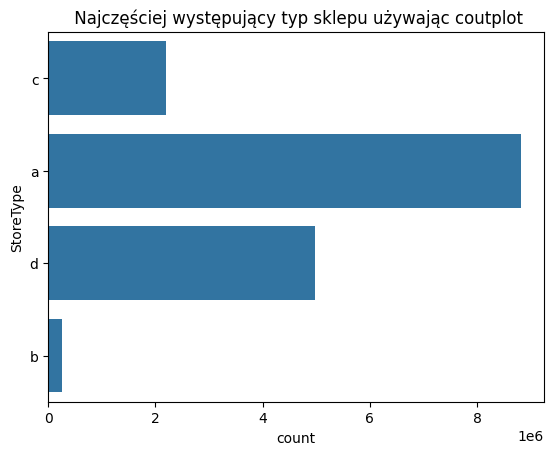

In [19]:
sns.countplot(merged_data['StoreType'])
plt.title(f" Najczęściej występujący typ sklepu używając coutplot")
plt.show()

Sprawdzamy jak typ sklepu wpływa na sprzedaż oraz liczbę odwiedzających 

In [20]:
# Grupowanie danych według typu sklepu i obliczenie sumy sprzedaży i liczby klientów dla każdej grupy
sales_customers_by_store_type = merged_data.groupby('StoreType')[['Sales', 'Customers']].sum().reset_index()
sales_customers_by_store_type

,StoreType,Sales,Customers
0,a,50591193232,5811269024
1,b,2547702320,503449936
2,c,12531542816,1474075280
3,d,28108710336,2496535760


Sklepy typu 'a' mają największą łączną sprzedaż (50,591,193,232) i największą liczbę klientów (5,811,269,024). Wydają się być dominujące pod względem ogólnych wyników sprzedaży i obsługi klienta \
Sklepy typu 'b' charakteryzują się najniższą łączną sprzedażą (2,547,702,320) i liczbą klientów (503,449,936) \
Sklepy typu 'c' zajmują środkową pozycję pod względem łącznej sprzedaży (12,531,542,816) i liczby klientów (1,474,075,280) \
Sklepy typu 'd' mają trzecią co do wielkości łączną sprzedaż (28,108,710,336), ale ich liczba klientów (2,496,535,760) jest niższa niż w sklepach typu 'a'

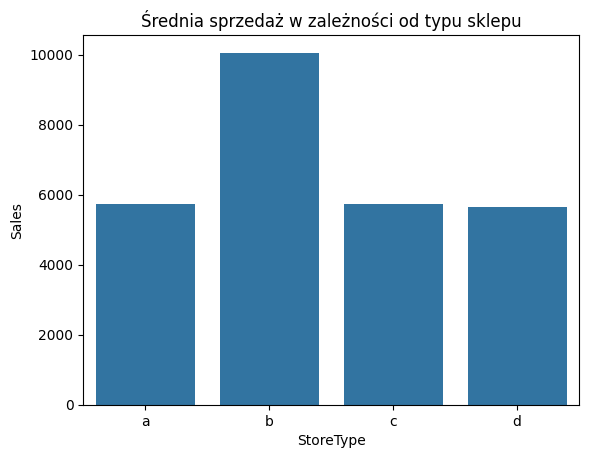

In [21]:
average_sales_by_store_type = merged_data.groupby('StoreType')['Sales'].mean().reset_index()

# Wykres średniej sprzedaży w zależności od typu sklepu
sns.barplot(x='StoreType', y='Sales', data=average_sales_by_store_type)
plt.title('Średnia sprzedaż w zależności od typu sklepu')
plt.show()


Typ sklepu 'b' charakteryzuje się najniższą łączną sprzedażą i liczbą odwiedzających, jednak z powyższego bar-plotu wynika, iż największa średnia sprzedaż w zależności od typu sklepu jest właśnie dla sklepu 'b'. Średnia sprzedaż dla typu sklepu 'b' jest najwyższa w porównaniu do innych typów sklepów. Może to wynikać z rodzaju asortymentu dostępnego w tym sklepie w porównaniu do innych, promocji bądź outlierów. Chcąc dokonać dalszego porównania typów sklepów, by móc wyciągnąć wnioski jak kategoryzowane są sklepy, poniżej przeprowadzono test statystyczny, który pozwoli zbadać, czy rozkłady asortymentów różnią się w sposób istotny statystycznie między różnymi typami sklepów. 

In [22]:
from scipy.stats import chi2_contingency
contingency_table = pd.crosstab(merged_data['StoreType'], merged_data['Assortment'])
chi2, p, _, _ = chi2_contingency(contingency_table)

# Wyniki
print(f"Statystyka chi-kwadrat: {chi2}")
print(f"P-wartość: {p}")

# Sprawdzamy, czy p-wartość jest mniejsza od poziomu istotności przyjętego 0.05
if p < 0.05:
    print("Stwierdzamy istotną różnicę między typem sklepu a asortymentem.")
else:
    print("Nie stwierdzono istotnej różnicy między typem sklepu a asortymentem.")

Statystyka chi-kwadrat: 9406508.018609982
P-wartość: 0.0
Stwierdzamy istotną różnicę między typem sklepu a asortymentem.


Stwierdzamy istotną różnicę między typem sklepu a asortymentem. Dlatego poniżej posłużono się analizą krzyżową celem dostarczenia informacji na temat rozkładu asortymentów w poszczególnych typach sklepów. 

In [24]:
cross_tab = pd.crosstab(merged_data['StoreType'], merged_data['Assortment'])
assortment_sums = cross_tab.sum(axis=1)
cross_tab['Total'] = assortment_sums
print(cross_tab)

Assortment        a       b        c    Total
StoreType                                    
a           5542224       0  3268736  8810960
b            105504  132704    15072   253280
c           1134048       0  1055392  2189440
d           1790144       0  3189248  4979392


Wnioski z analizy krzyżowej pomiędzy typem sklepu a asortymentem: \
Typ sklepu a: \
Asortyment a w sklepie a: 5542224 \
Asortyment b w sklepie a: 0 \
Asortyment c w sklepie a: 3268736 \
Typ sklepu b: \
 Asortyment a w sklepie b: 105504 \
 Asortyment b w sklepie b: 132704 \
 Asortyment c w sklepie b: 15072 \
 Typ sklepu c: \
 Asortyment a w sklepie c: 1134048 \
 Asortyment b w sklepie c: 0 \
 Asortyment c w sklepie c: 1055392 \
 Typ sklepu d: \
 Asortyment a w sklepie d: 1790144 \
 Asortyment b w sklepie d: 0 \
 Asortyment c w sklepie d: 3189248 \
 \
 Sklepy typu 'b' posiadają najbardziej zróżnicowany asortyment, obejmujący wszystkie poziomy ('a', 'b', 'c'). Asortyment 'b' wydaje się być bardziej charakterystyczny dla sklepów typu 'b'. Sklepy typu 'a', 'c', 'd' posiadają głównie asortymenty 'a' i 'c',  ale nie posiadają asortymentu 'b'. \ 
 \
 Sumy wskazują na to, że najwięcej asortymentu niezależnie od podziału na typ posiadają sklepy typu 'a', następnie typu 'd', kolejno typu 'c' i najmniej typu 'b'.

 


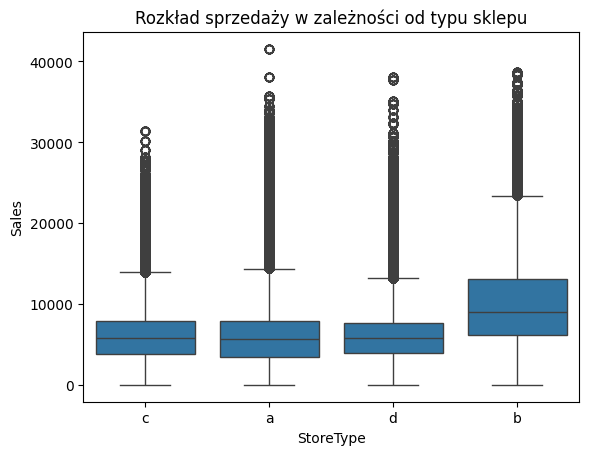

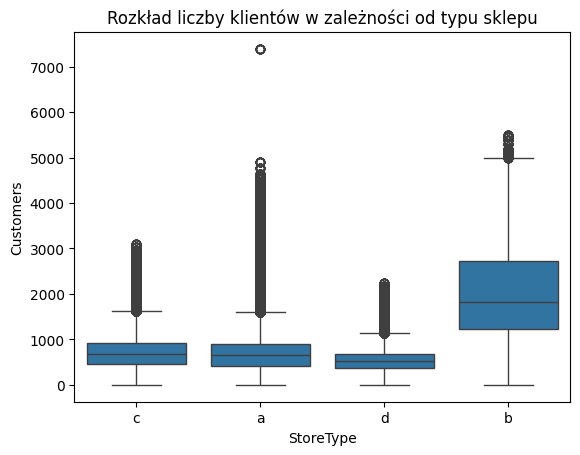

In [116]:
# Wykresy rozkładu danych
sns.boxplot(x='StoreType', y='Sales', data=merged_data)
plt.title('Rozkład sprzedaży w zależności od typu sklepu')
plt.show()

sns.boxplot(x='StoreType', y='Customers', data=merged_data)
plt.title('Rozkład liczby klientów w zależności od typu sklepu')
plt.show()

Sklep typu b cechuje się wyższą medianą zarówno pod względem wyników sprzedaży jak i liczby klientów odwiedzających sklep. Równocześnie sklep b cechuje się większym rozrzutem danych zarówno pod względem wyników sprzedaży jak i liczby klientów odwiedzających sklep w porównaniu do sklepów innego typu. Sklepy a, c, d mają spójniejsze wyniki sprzedażowe i pod względem liczby klientów. Różnice między typami sklepów w kontekście wyników sprzedażowych i pod względem liczby klientów są znaczące między typem b a pozostałymi. \
Chcąc znaleźć sposób, który pozwoli stwierdzić co mogą oznaczać typy sklepów a,b,c,d, obliczono średni czas otwarcia każdego z typów sklepow. Z poniższych wyników wynika, iż sklep typu b cechuje się najwyższym średnim czasem otwarcia. 

<Axes: title={'center': 'Średni czas otwarcia sklepów'}, xlabel='Typ Sklepu', ylabel='Średni czas otwarcia'>

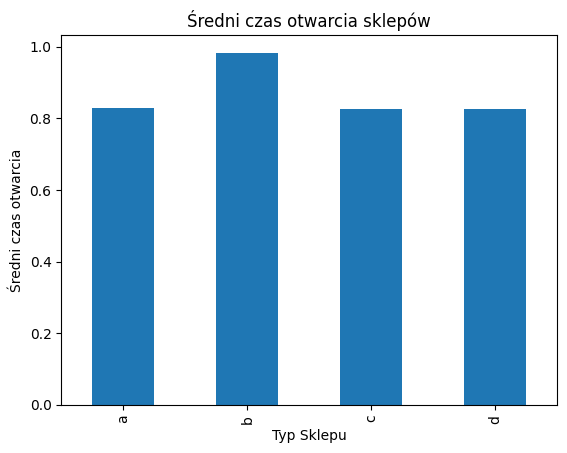

In [117]:
avg_open_time = merged_data.groupby('StoreType')['Open'].mean()
avg_open_time.plot(kind='bar', xlabel='Typ sklepu', ylabel='Średni czas otwarcia', title='Średni czas otwarcia sklepów')

Wiemy już, że typ sklepu 'a' dotyczy sklepów z najwyższą sprzedażą oraz liczbą odwiedzających, a także największym asortymentem (ale nie najbardziej różnorodnym). Typ 'b' wyróżnia się najbardziej zróżnicowanym asortymentem (gdyż zawiera wszystkie trzy typy asortymentu). 

In [26]:
from scipy.stats import chi2_contingency
localization_data = merged_data[['StoreType', 'State']]

# Tworzenie tabeli przestawnej (pivot table)
pivot_table = pd.pivot_table(localization_data, index='State', columns='StoreType', aggfunc=len, fill_value=0)

# Przeprowadzenie testu chi-kwadrat
chi2, p, _, _ = chi2_contingency(pivot_table)

# Wyniki
print(f"Statystyka chi-kwadrat: {chi2}")
print(f"P-wartość: {p}")

# Sprawdzamy, czy p-wartość jest mniejsza od poziomu istotności przyjętego 0.05
if p < 0.05:
    print("Stwierdzamy istotną różnicę między lokalizacją a typem sklepu.")
else:
    print("Nie stwierdzono istotnej różnicy między lokalizacją a typem sklepu.")

Statystyka chi-kwadrat: 2088307.9508889026
P-wartość: 0.0
Stwierdzamy istotną różnicę między lokalizacją a typem sklepu.


P-wartość wynosząca 0.0 jest mniejsza niż przyjęty poziom istotności (0.05), co oznacza, że możemy odrzucić hipotezę zerową o braku zależności między lokalizacją a typem sklepu. W praktyce oznacza to, że lokalizacja (stan) może mieć wpływ na przypisanie typów sklepów. Sprawdzono poniżej jaki typ sklepu pojawiał się najczęściej w konkretnym landzie.

Procentowy udział poszczególnych typów sklepów w każdym landzie:
StoreType          a         b          c          d
State                                               
BE         58.695652  5.434783  23.913043  11.956522
BW         45.205479  2.739726  17.808219  34.246575
BY         46.927374  0.558659   7.821229  44.692737
HB,NI      54.545455  4.545455  22.727273  18.181818
HE         35.714286  2.678571  10.714286  50.892857
HH         60.714286  3.571429  28.571429   7.142857
NW         66.083916  1.048951   7.692308  25.174825
RP         30.000000  2.500000   7.500000  60.000000
SH         64.034753  0.000000  10.526414  25.438833
SN         50.000000  0.000000  25.675676  24.324324
ST         53.571429  0.000000  19.642857  26.785714
TH         55.555556  0.000000  19.444444  25.000000


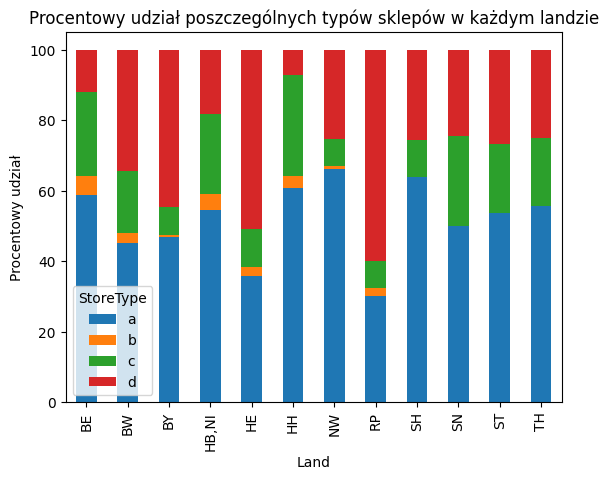

In [29]:
# Tabela przestawna dla landów i typów sklepów
pivot_table_land_type = pd.pivot_table(localization_data, index='State', columns='StoreType', aggfunc=len, fill_value=0)

# Procentowy udział poszczególnych typów sklepów w każdym landzie
percentage_land_type = pivot_table_land_type.div(pivot_table_land_type.sum(axis=1), axis=0) * 100

# Wyniki
print("Procentowy udział poszczególnych typów sklepów w każdym landzie:")
print(percentage_land_type)

# Wykres słupkowy dla landów i procentowego udziału typów sklepów
percentage_land_type.plot(kind='bar', stacked=True)
plt.title('Procentowy udział poszczególnych typów sklepów w każdym landzie')
plt.xlabel('Land')
plt.ylabel('Procentowy udział')
plt.show()


Landy sąsiadujące posiadają zbliżone rozkłady typów sklepów na swoich powierzchniach. Jednak nie da się jednoznaczenie powiązać typów do części wschodniej, czy zachodniej Niemiec bądź znaleźć konkretnego schematu, gdyż np. sklepów typu 'b' nie ma zarówno w landzie SchleswigHolstein należącym do zachodniej części Niemiec oraz nie ma w landzie Sachsen, który leży we wschodniej części Niemiec. 

In [31]:
unique_states = merged_data[['State', 'StateName']].drop_duplicates()
print(unique_states)

        State           StateName
0          HE              Hessen
15072      TH          Thueringen
30144      NW  NordrheinWestfalen
45216      BE              Berlin
60288      SN             Sachsen
90432      SH   SchleswigHolstein
135648  HB,NI       Niedersachsen
180864     BY              Bayern
223136     BW   BadenWuerttemberg
322752     RP      RheinlandPfalz
398112     ST       SachsenAnhalt
672704     HH             Hamburg


Poniżej sprawdzono, czy istnieje zależność pomiędzy promocją a przypisaniem typu sklepu. Nie stwierdzono istotnej różnicy pomiędzy promocją a typem sklepu. 

In [32]:
from scipy.stats import chi2_contingency

# Tworzenie tabeli przestawnej (pivot table) dla promocji i typów sklepów
promotion_data = merged_data[['StoreType', 'Promo']]

pivot_table_promo = pd.pivot_table(promotion_data, index='StoreType', columns='Promo', aggfunc=len, fill_value=0)

# Przeprowadzenie testu chi-kwadrat
chi2, p, _, _ = chi2_contingency(pivot_table_promo)

# Wyniki
print(f"Statystyka chi-kwadrat: {chi2}")
print(f"P-wartość: {p}")

# Sprawdzamy, czy p-wartość jest mniejsza od poziomu istotności przyjętego 0.05
if p < 0.05:
    print("Stwierdzamy istotną różnicę między promocją a typem sklepu.")
else:
    print("Nie stwierdzono istotnej różnicy między promocją a typem sklepu.")


Statystyka chi-kwadrat: 3.0304484877678353
P-wartość: 0.386954401479962
Nie stwierdzono istotnej różnicy między promocją a typem sklepu.


# Wnioski do zadania dotyczącego oznaczania typów sklepów a, b, c, d

Sklep typu 'a' cechuje się najwyższym obrotem handlowym, a także największą liczbą odwiedzających. Dodatkowo ten typ sklepu występuje najczęściej. Znaczny udział w każdym landzie sugeruje, że to może być typ standardowy sklepu, obejmujący szeroki zakres produktów.\
Sklep typu 'b' cechuje się najbardziej zróżnicowanym asortymentem (zawiera wszystkie trzy poziomy asortymentu a, b, c), podczas gdy typy a, c, d nie posiadają asortymentu 'b'. Dodatkowo sklepy typu 'b' nie występują we wszystkich landach (nie pojawiają się w SH, SN, ST, TH). Dla typu sklepu 'b' określono też najwyższy wynik średniego czasu otwarcia sklepów. Możliwe, że ten typ sklepu określa małe punkty umiejscowione w newralgicznych miejscach i cechujące się ponadprzeciętnymi godzinami otwarcia, co wyjaśniałoby najwyższą średnią sprzedaż w tym typie sklepu. \
Sklep typu 'd' zajmuje drugie miejsce pod względem obrotu handlowego, liczby klientów oraz wielkości asortymentu (wielkości, nie różnorodności). Są landy, w których typ sklepu 'd' dominuje, co może oznaczać oferanie rozszerzonego asortymentu i dodatkowych usług spersonalizowanych pod mieszkańców tych landów. \
Sklep typu 'c' zajmuje trzecie miejsce pod względem obrotu handlowego, liczby klientów oraz wielkości asortymentu (wielkości, nie różnorodności)

Procentowe udziały poszczególnych typów sklepów w landach są zbliżone w landach sąsiadujących. Test chi-kwadrat wskazał istotną różnicę między lokalizacją a typem sklepu. \
\
Nie stwierdzono istotnej różnicy między promocją a typem sklepu.

Typ sklepu - OLS

In [33]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Przypisanie zmiennych
X = pd.get_dummies(merged_data['StoreType'], prefix='StoreType', drop_first=True)
y = merged_data['Sales']

# Podział na train i test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stworzenie modelu regresji
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

# Wyświetlenie podsumowania modelu
print(model.summary())

# Sprawdzenie współczynników istotności statystycznej
p_values = model.pvalues
print("\nWspółczynniki istotności statystycznej:")
print(p_values)

# Ogólny wpływ typu sklepu na sprzedaż
print("\nOgólny wpływ Typu sklepu na sprzedaż:")
print("Współczynniki regresji:")
print(model.params)

# Sprawdzenie modelu na danych testowych
y_pred = model.predict(sm.add_constant(X_test))
mse = mean_squared_error(y_test, y_pred)
print("\nŚredni błąd kwadratowy (MSE) na danych testowych:", mse)


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                 8.693e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        03:32:20   Log-Likelihood:            -1.2551e+08
No. Observations:            12986457   AIC:                         2.510e+08
Df Residuals:                12986453   BIC:                         2.510e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5741.1047      1.436   3997.879      

# Typ sklepu - wnioski ze znaczenia cechy

Tu wpisz wnioski!!!

# Analiza: 2. Dni wolne od nauki szkolnej

In [103]:
# Zależność między wskaźnikiem Open a Wynikami Sprzedażowymi:
correlation = merged_data[['Open', 'Sales']].corr()
print(correlation)

           Open     Sales
Open   1.000000  0.678637
Sales  0.678637  1.000000


Korelacja między wskaźnikiem Open a sprzedażą wynosi około 0.68, co wskazuje na umiarkowaną dodatnią korelację między tymi dwoma zmiennymi. Gdy wskaźnik Open jest wysoki, istnieje tendencja do większej sprzedaży